Company XYZ sells a software for 39. Since revenue has been ﬂat for some time, the VP of Product has decided to run a test increasing the price. She hopes that this would increase revenue. In the experiment, 66% of the users have seen the old price (39), while a random sample of 33% users a higher price (59).

The test has been running for some time and the VP of Product is interested in understanding how it went and whether it would make sense to increase the price for all the users.

Especially he asked you the following questions:

* Should the company sell its software for 39 or 59?
* The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main ﬁndings looking at the data?

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2,f_classif
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from matplotlib import pyplot as plt
import seaborn as sns

## 1. Load the data

In [2]:
df_original = pd.read_csv("test_results.csv",index_col="user_id")

In [3]:
df_original.head()

,timestamp,source,device,operative_system,test,price,converted
user_id,,,,,,,
604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [4]:
df = df_original.copy()
df

In [9]:
df.shape

(316800, 7)

In [11]:
# Check missing values
# this dataset doesn't have missing value
df.isnull().sum()

timestamp           0
source              0
device              0
operative_system    0
test                0
price               0
converted           0
dtype: int64

In [12]:
# check the "converted" columns to see the mean of it
# the mean is 0.01833, which means the overall convertion rate is around 18%
df.describe()

,test,price,converted
count,316800.000000,316800.000000,316800.000000
mean,0.360079,46.205051,0.018333
std,0.480024,9.601487,0.134154
min,0.000000,39.000000,0.000000
25%,0.000000,39.000000,0.000000
50%,0.000000,39.000000,0.000000
75%,1.000000,59.000000,0.000000
max,1.000000,59.000000,1.000000


# 2. Data Processing

### (1) Check whether test and control group is randomly splitted?

In [13]:
# drop the timestamp, because in this projct time feature is not important
df_test = df.drop(columns = 'timestamp')

# convert string to number for checking feature importance in the futrue
source_label_encoder = LabelEncoder()
device_label_encoder = LabelEncoder()
os_label_encoder = LabelEncoder()

df_test['source'] = source_label_encoder.fit_transform(df_test['source'])
df_test['device'] = device_label_encoder.fit_transform(df_test['device'])
df_test['operative_system'] = os_label_encoder.fit_transform(df_test['operative_system'])

In [14]:
df_test.head()

,source,device,operative_system,test,price,converted
user_id,,,,,,
604839,3,0,1,0,39,0
624057,8,0,0,0,39,0
317970,0,0,0,0,39,0
685636,5,0,1,1,59,0
820854,3,1,3,0,39,0


In [15]:
#We use Chi-Square test to check whether test and control group is randomly splitted
colnames = ["source","device","operative_system"]
ch2values,pvalues = chi2(df_test.loc[:,colnames],df_test["test"])
pd.DataFrame({'chi2_value':ch2values,'p-value':pvalues},index = colnames).sort_values(by='p-value')

,chi2_value,p-value
operative_system,83.085986,7.856065e-20
device,44.366335,2.723301e-11
source,0.924742,3.362329e-01


* As we can see above, since the p-value of "operative_system" and "device" are way less than 0.05, the splitting between test and control groups **is not random**. It will effect the accuracy of the result.

In [16]:
df.groupby('test')['operative_system'].value_counts(normalize=True).unstack()

operative_system,android,iOS,linux,mac,other,windows
test,,,,,,
0,0.237807,0.305115,0.010887,0.080729,0.051784,0.313678
1,0.234280,0.294636,0.016901,0.076434,0.050021,0.327729


In [17]:
df.groupby('operative_system')['test'].value_counts(normalize=True).unstack()

test,0,1
operative_system,,
android,0.643358,0.356642
iOS,0.647934,0.352066
linux,0.533736,0.466264
mac,0.652422,0.347578
other,0.647865,0.352135
windows,0.629764,0.370236


### (2) Check if any users have been assigned to the wrong group

In [18]:
df[['test','price','device']].groupby(['test','price']).count()

device
test price        
0    39     202517
     59        210
1    39        155
     59     113918

* As we can see above, there are a small amount of users have been assigned to the worng group, we have to fix the problems.

* Because there are not so many users have been assigned to the wrong group, we can drop them.

In [19]:
# we keep the users who have been correctly assigned
df = df[((df['test']==0)&(df['price']==39)) | ((df['test']==1)&(df['price']==59))]

In [69]:
df.groupby(['test','price'])[['test','price','device']].count()

,,test,price,device
test,price,,,
0,39,202517,202517,202517
1,59,113918,113918,113918


Now, as we can see, every user is in the right group

### (3). Data engineering 

We create a **revenue** column for us to understand the revenue situation 

In [21]:
df['revenue'] = df['converted'] * df['price']
df.head()

,timestamp,source,device,operative_system,test,price,converted,revenue
user_id,,,,,,,,
604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,0
624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,0
317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,0
685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,0
820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,0


# 3. EDA

### (1) Source

In [28]:
source_in_test = df.groupby('test')['source'].value_counts(normalize=True).unstack()
source_in_test

source,ads-bing,ads-google,ads-yahoo,ads_facebook,ads_other,direct_traffic,friend_referral,seo-bing,seo-google,seo-other,seo-yahoo,seo_facebook
test,,,,,,,,,,,,
0,0.072014,0.186873,0.023761,0.168253,0.095083,0.191154,0.064790,0.006562,0.074502,0.029030,0.021509,0.066468
1,0.072394,0.188706,0.024219,0.169253,0.092786,0.189259,0.066337,0.007154,0.070753,0.029539,0.021814,0.067786


<AxesSubplot:xlabel='test'>

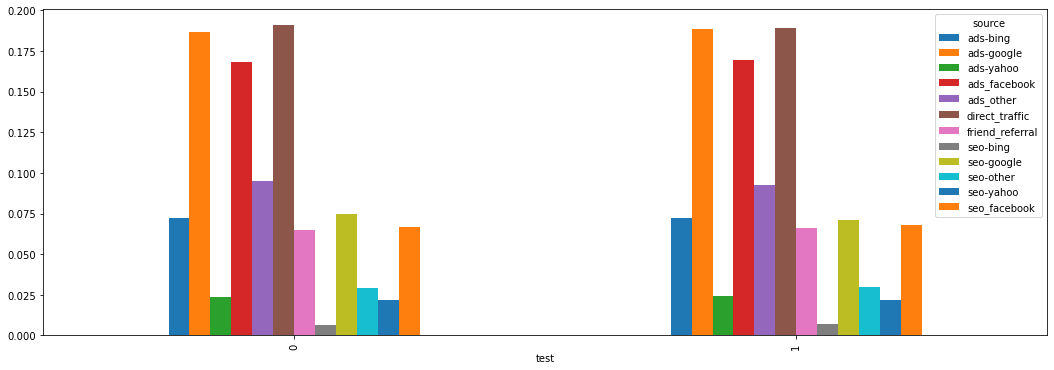

In [29]:
fig, ax = plt.subplots(figsize=(18,6))
source_in_test.plot(kind='bar', ax=ax)

In [30]:
test_in_source = df.groupby('source')['test'].value_counts(normalize=True).unstack()
test_in_source

test,0,1
source,,
ads-bing,0.638781,0.361219
ads-google,0.637744,0.362256
ads-yahoo,0.635583,0.364417
ads_facebook,0.638628,0.361372
ads_other,0.645611,0.354389
direct_traffic,0.642288,0.357712
friend_referral,0.634539,0.365461
seo-bing,0.619869,0.380131
seo-google,0.651806,0.348194


<AxesSubplot:xlabel='source'>

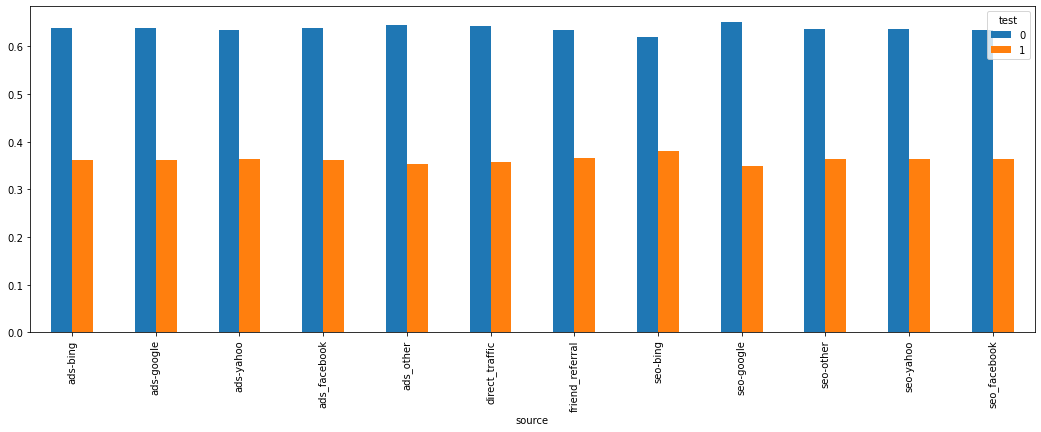

In [31]:
fig, ax = plt.subplots(figsize=(18,6))
test_in_source.plot(kind='bar', ax=ax)

Text(0.5, 1.0, 'Mean Revenue vs. Source')

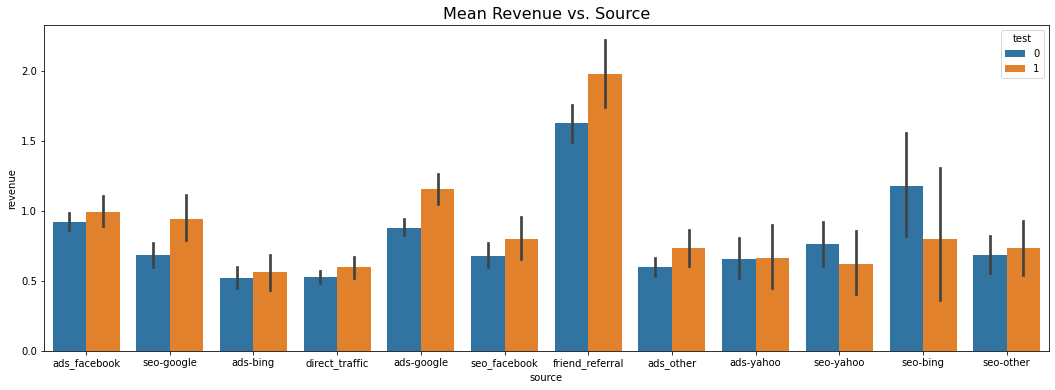

In [32]:
fig, ax = plt.subplots(figsize=(18, 6))
ax = sns.barplot(x='source', y='revenue', hue='test', data=df)
ax.set_title('Mean Revenue vs. Source', fontsize=16)

As we can see above,
* "friend_referral" can generate the highest revenue
* "seo-bing" can generate very high revenue, even higher than Google and FB
* When we compare eahc source between test and control group, 9 out of the 12 comparisons shows that test group users can generate higher revenue than control group users

### (2) Device

In [33]:
device_in_test = df.groupby('test')['device'].value_counts(normalize=True).unstack()
device_in_test

device,mobile,web
test,,
0,0.594365,0.405635
1,0.578469,0.421531


<AxesSubplot:xlabel='test'>

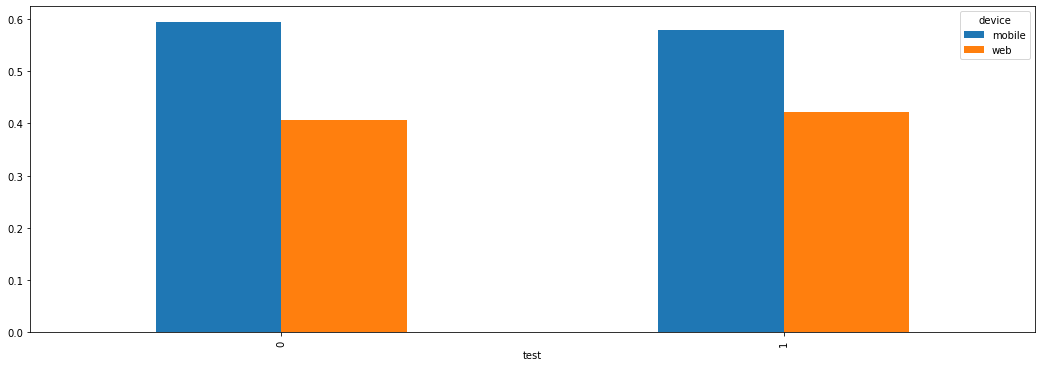

In [34]:
fig, ax = plt.subplots(figsize=(18,6))
device_in_test.plot(kind='bar', ax=ax)

In [35]:
test_in_device = df.groupby('device')['test'].value_counts(normalize=True).unstack()
test_in_device

test,0,1
device,,
mobile,0.646218,0.353782
web,0.631092,0.368908


<AxesSubplot:xlabel='device'>

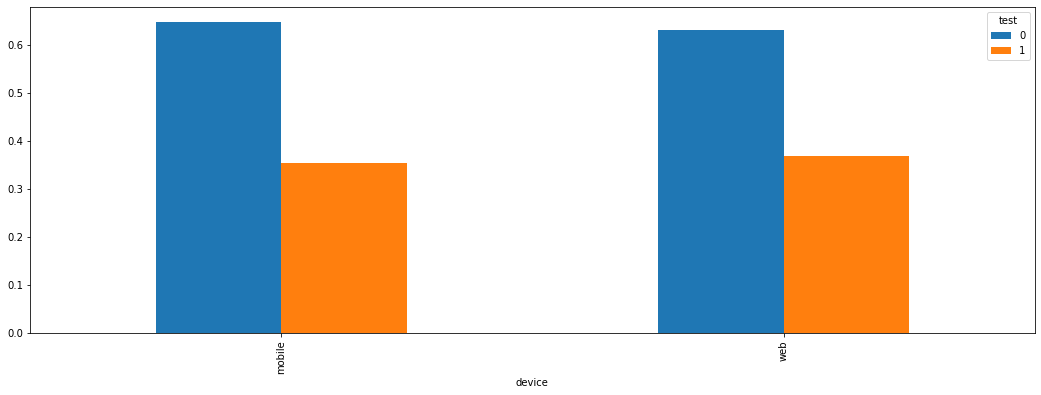

In [36]:
fig, ax = plt.subplots(figsize=(18,6))
test_in_device.plot(kind='bar', ax=ax)

Text(0.5, 1.0, 'Mean Revenue vs. Device')

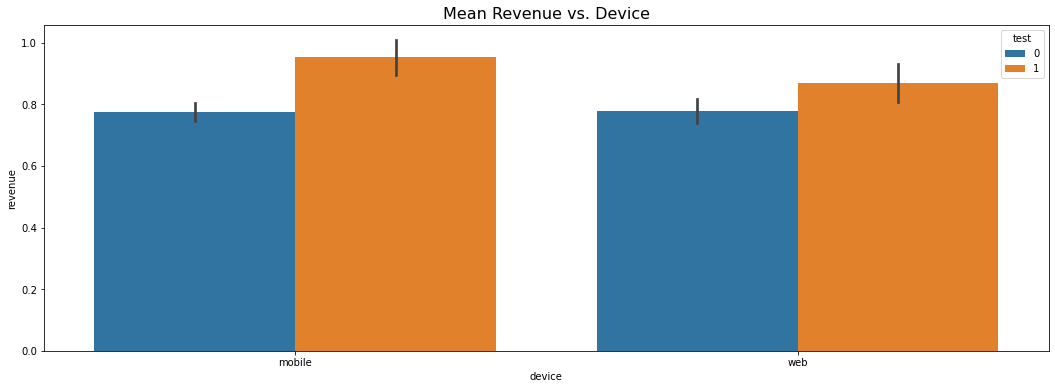

In [37]:
# bar chart
fig, ax = plt.subplots(figsize=(18, 6))
ax = sns.barplot(x='device', y='revenue', hue='test', data=df)
ax.set_title('Mean Revenue vs. Device', fontsize=16)

* The test group can generate higher revenue in both "mobile" and "web" device
* "mobile" users can gnerate slight higher revenue than "web" users, but not significant 

### (3) operative_system

In [38]:
operative_system_in_test = df.groupby('test')['operative_system'].value_counts(normalize=True).unstack()
operative_system_in_test

operative_system,android,iOS,linux,mac,other,windows
test,,,,,,
0,0.237891,0.305125,0.010883,0.080709,0.051754,0.313638
1,0.234318,0.294598,0.016907,0.076459,0.050001,0.327718


<AxesSubplot:xlabel='test'>

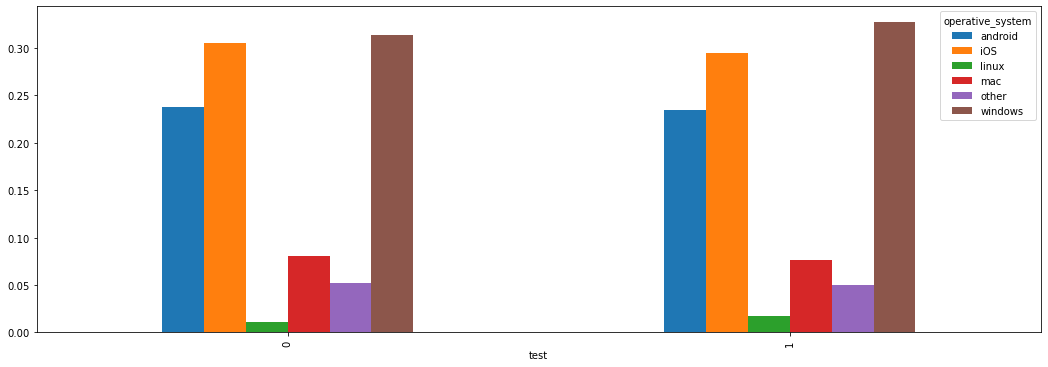

In [39]:
fig, ax = plt.subplots(figsize=(18,6))
operative_system_in_test.plot(kind='bar', ax=ax)

In [40]:
test_in_operative_system = df.groupby('operative_system')['test'].value_counts(normalize=True).unstack()
test_in_operative_system

test,0,1
operative_system,,
android,0.643475,0.356525
iOS,0.648045,0.351955
linux,0.533656,0.466344
mac,0.652365,0.347635
other,0.647895,0.352105
windows,0.629817,0.370183


<AxesSubplot:xlabel='operative_system'>

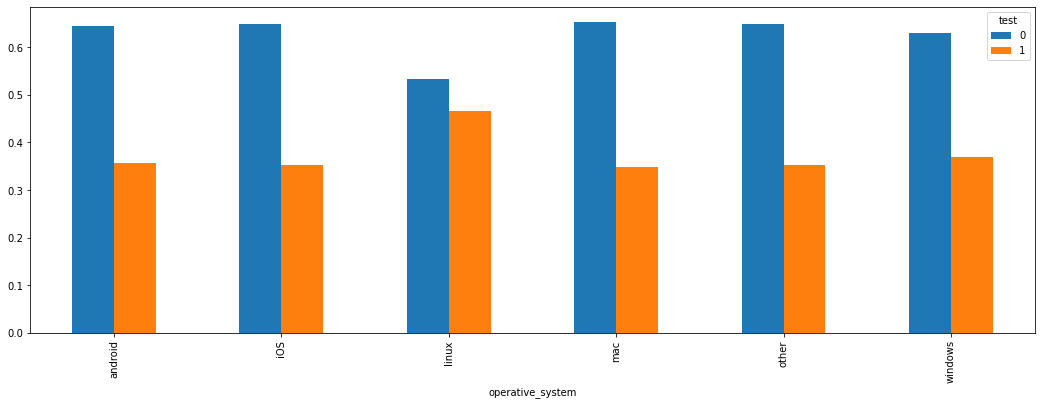

In [41]:
fig, ax = plt.subplots(figsize=(18,6))
test_in_operative_system.plot(kind='bar', ax=ax)

Text(0.5, 1.0, 'Mean Revenue vs. operative system')

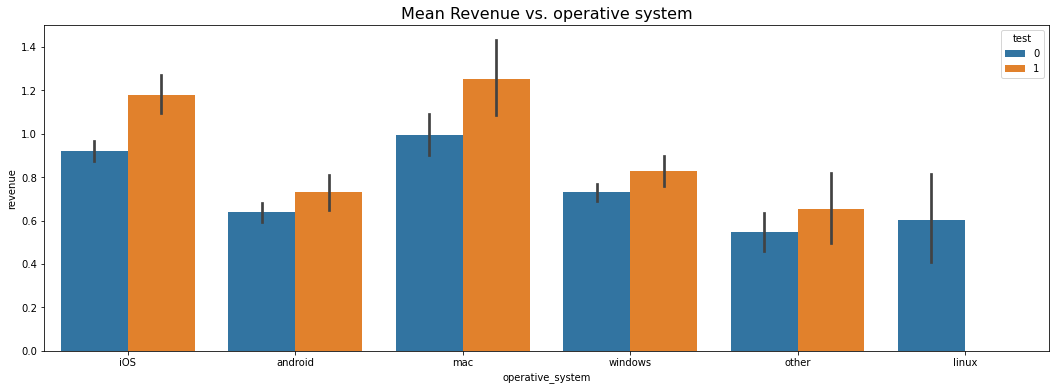

In [42]:
# bar chart
fig, ax = plt.subplots(figsize=(18, 6))
ax = sns.barplot(x='operative_system', y='revenue', hue='test', data=df)
ax.set_title('Mean Revenue vs. operative system', fontsize=16)

In [68]:
df.groupby(['operative_system','test'])[['operative_system','test','revenue']].sum()

test  revenue
operative_system test                
android          0         0    30693
                 1     26693    19470
iOS              0         0    56862
                 1     33560    39589
linux            0         0     1326
                 1      1926        0
mac              0         0    16224
                 1      8710    10915
other            0         0     5733
                 1      5696     3717
windows          0         0    46332
                 1     37333    30857

* "linux" wasn't splitted correctly, it didn't follow the rule of 66% control and 33% test
* "mac" and "ios" users can generate higher revenue
* The test group of "linux" didn't generate any revenue

## Question01.
**Should the company sell its software for 39 or 59?**


In [45]:
# check each group's average revenue
# check each group's average converted rate
def show_revenue_converted(df):
    return pd.Series({'average revenue':df['revenue'].mean(),
                      'average conversion rate':df['converted'].mean(),
                      'number of users':df.shape[0]})
df.groupby('test').apply(show_revenue_converted)

,average revenue,average conversion rate,number of users
test,,,
0,0.776083,0.019900,202517.0
1,0.917748,0.015555,113918.0


As we can see above:
* the test group's average revenue is higher than control group's average revenue
* the test group's average conversion rate is lower than control group's average conversion rate, which makes sense, bacause test group's price($\$59$) is higher than control gorup($\$39$)

### We are going to do a hypothesis testing and perform a t-test to see whether the test group's average revenue is acutally higher than control group's average revenue

* H0: test group's average revenue equal to control group's average revenue
* H1: test group's average revenue is higher than control group's average revenue

In [46]:
# set up the two distribution for t test
control_revenue = df[df['test'] == 0]['revenue']
test_revenue = df[df['test'] == 1]['revenue']

In [47]:
ttest_result = ss.ttest_ind(control_revenue, test_revenue, axis=0, equal_var=False)
print(ttest_result)

# Because this is a one-tailed test, so we have to divide the p-vale by 2
print('For one-tailed test p-value: ',ttest_result.pvalue/2)

Ttest_indResult(statistic=-5.715224666463108, pvalue=1.0972577312420781e-08)
For one-tailed test p-value:  5.486288656210391e-09


##### Based on the result:
* The p-value is way samller than 0.05 threshold, we reject H0, and accept H1, that is
* **The test group's average revenue is significantly higher than control group's average revenue**

\* BUT! because the operative_system distributions are not the same between test and contorl group, price is not only difference between test and contorl group. Therefore the above result is not scientifically accurate. More A/B test is needed.

## Answer question02
**The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main ﬁndings looking at the data?**

In [48]:
# we use df_test, becuase it has been transformed by LabelEncoder
df_test.head(10)

,source,device,operative_system,test,price,converted
user_id,,,,,,
604839,3,0,1,0,39,0
624057,8,0,0,0,39,0
317970,0,0,0,0,39,0
685636,5,0,1,1,59,0
820854,3,1,3,0,39,0
169971,1,0,1,0,39,0
600150,11,1,5,0,39,0
798371,0,0,0,1,59,1
447194,3,1,5,1,59,0


### (1) Chi-Square test
We can use **Chi-Square test** to find which feature have great impact on conversion rate

In [49]:
colnames = ["source","device","operative_system",'price']
ch2values, p_value = chi2(df_test.loc[:,colnames],df_test["converted"])
pd.DataFrame({'chi2_value':ch2values,'p-value':p_value},index = colnames).sort_values(by='p-value')

,chi2_value,p-value
price,150.992849,1.051844e-34
operative_system,7.642955,5.699447e-03
source,2.373391,1.234187e-01
device,0.729490,3.930485e-01


#### Based on the result
* **"Price"** and **"operative_system"** have very small p-value, which mean the the difference of "Price" and "operative_system" make big impact on conversion rate
* "Source" and "Device" don't impact conversion rate that much.

### (2) How price affects conversion?

In [50]:
price_to_coversion= df.groupby("price")['converted'].value_counts(normalize=True).unstack()
price_to_coversion

converted,0,1
price,,
39,0.980100,0.019900
59,0.984445,0.015555


In [51]:
price_to_avg_coversion= df.groupby("price")['converted'].mean().reset_index()
price_to_avg_coversion

,price,converted
0,39,0.019900
1,59,0.015555


* $\$39$ will cause higher conversion rate than $\$59$.

### (3) How operative system affects conversion?

In [52]:
os_to_coversion = df.groupby("operative_system")['converted'].value_counts(normalize=True).unstack()
os_to_coversion.sort_values(by=1,ascending=False)

converted,0,1
operative_system,,
mac,0.976013,0.023987
iOS,0.977672,0.022328
windows,0.983034,0.016966
android,0.985081,0.014919
other,0.987019,0.012981
linux,0.991768,0.008232


In [53]:
os_to_avg_coversion = df.groupby('operative_system')['converted'].mean().sort_values(ascending=False).reset_index()
os_to_avg_coversion

,operative_system,converted
0,mac,0.023987
1,iOS,0.022328
2,windows,0.016966
3,android,0.014919
4,other,0.012981
5,linux,0.008232


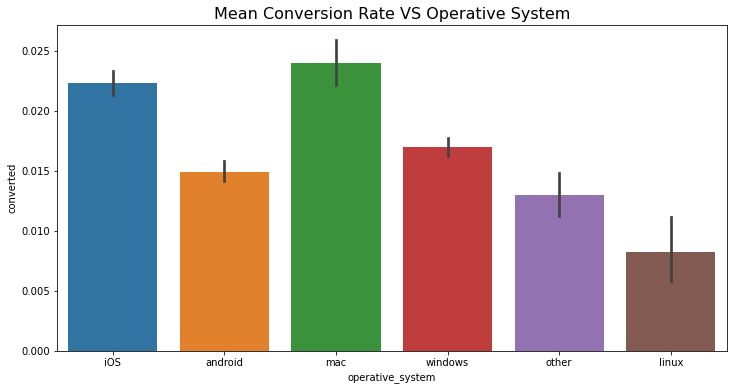

In [54]:
# Visualization of operative system
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='operative_system', y='converted', data=df)
ax.set_title('Mean Conversion Rate VS Operative System', fontsize=16)
plt.show()

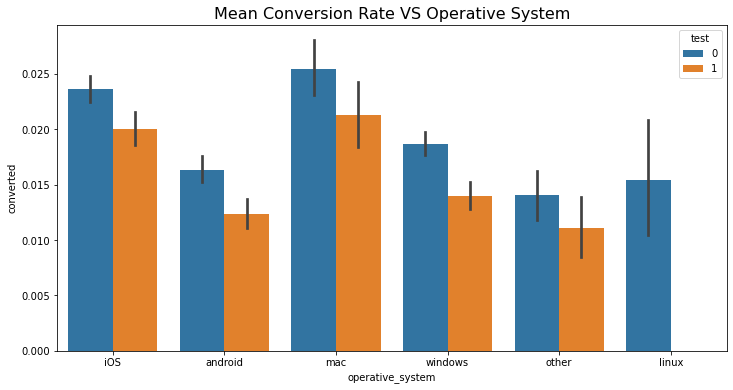

In [55]:
# Visualization of operative system
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='operative_system', y='converted', hue='test', data=df)
ax.set_title('Mean Conversion Rate VS Operative System', fontsize=16)
plt.show()

##### As we can see above
* "Mac" and "iOS" users have higher conversion rate than other OS users
* "Linux" users have the lowest conversion rate 

### (4) Model by Decision Tree
Use Decision Tree Model to get feature importance. Since the question is asking about "actionable insight" , we don't have to build a model to make prediction, so we just need to look at how Decision Tree Model choose the features.

In [56]:
df_original.head()

,timestamp,source,device,operative_system,test,price,converted
user_id,,,,,,,
604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [57]:
df_test02= df_original.drop(columns='timestamp')
df_test02= df_test02.drop(columns='test')
df_test02

,source,device,operative_system,price,converted
user_id,,,,,
604839,ads_facebook,mobile,iOS,39,0
624057,seo-google,mobile,android,39,0
317970,ads-bing,mobile,android,39,0
685636,direct_traffic,mobile,iOS,59,0
820854,ads_facebook,web,mac,39,0
...,...,...,...,...,...
17427,ads_facebook,web,windows,39,0
687787,direct_traffic,web,windows,39,0
618863,ads-google,web,mac,39,0


In [58]:
df_test02['source'].value_counts().reset_index()

,index,source
0,direct_traffic,60357
1,ads-google,59379
2,ads_facebook,53396
3,ads_other,29876
4,seo-google,23175
5,ads-bing,22873
6,seo_facebook,21205
7,friend_referral,20695
8,seo-other,9260
9,ads-yahoo,7583


In [59]:
df_test02['device'].value_counts().reset_index()

,index,device
0,mobile,186471
1,web,130329


In [60]:
df_test02['operative_system'].value_counts().reset_index()

,index,operative_system
0,windows,100976
1,iOS,95465
2,android,74935
3,mac,25085
4,other,16204
5,linux,4135


In [61]:
# we use One-Hot-Encoding on categorical features
df_test02 = pd.get_dummies(df_test02)

# a categorical feature of n unique values, only need n-1 vectors
# I don't use 'drop_first' parameter in get_dummies, since it cannot specify which level to drop
df_test02 = df_test02.drop(columns='source_ads_other')
df_test02 = df_test02.drop(columns='device_web')
df_test02 = df_test02.drop(columns='operative_system_other')
df_test02.sample(10)

,price,converted,source_ads-bing,source_ads-google,source_ads-yahoo,source_ads_facebook,source_direct_traffic,source_friend_referral,source_seo-bing,source_seo-google,source_seo-other,source_seo-yahoo,source_seo_facebook,device_mobile,operative_system_android,operative_system_iOS,operative_system_linux,operative_system_mac,operative_system_windows
user_id,,,,,,,,,,,,,,,,,,,
334379,39,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
529049,59,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
613851,39,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
371068,39,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0
203265,39,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
930225,59,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
768055,39,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
842750,39,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
32296,59,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [62]:
X_train = df_test02.loc[:,df_test02.columns != 'converted']
y_train = df_test02.loc[:,'converted']

In [63]:
X_train.head()

,price,source_ads-bing,source_ads-google,source_ads-yahoo,source_ads_facebook,source_direct_traffic,source_friend_referral,source_seo-bing,source_seo-google,source_seo-other,source_seo-yahoo,source_seo_facebook,device_mobile,operative_system_android,operative_system_iOS,operative_system_linux,operative_system_mac,operative_system_windows
user_id,,,,,,,,,,,,,,,,,,
604839,39,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0
624057,39,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0
317970,39,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
685636,59,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0
820854,39,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


In [64]:
y_train.head()

user_id
604839    0
624057    0
317970    0
685636    0
820854    0
Name: converted, dtype: int64

In [65]:
X_train.columns

Index(['price', 'source_ads-bing', 'source_ads-google', 'source_ads-yahoo',
       'source_ads_facebook', 'source_direct_traffic',
       'source_friend_referral', 'source_seo-bing', 'source_seo-google',
       'source_seo-other', 'source_seo-yahoo', 'source_seo_facebook',
       'device_mobile', 'operative_system_android', 'operative_system_iOS',
       'operative_system_linux', 'operative_system_mac',
       'operative_system_windows'],
      dtype='object')

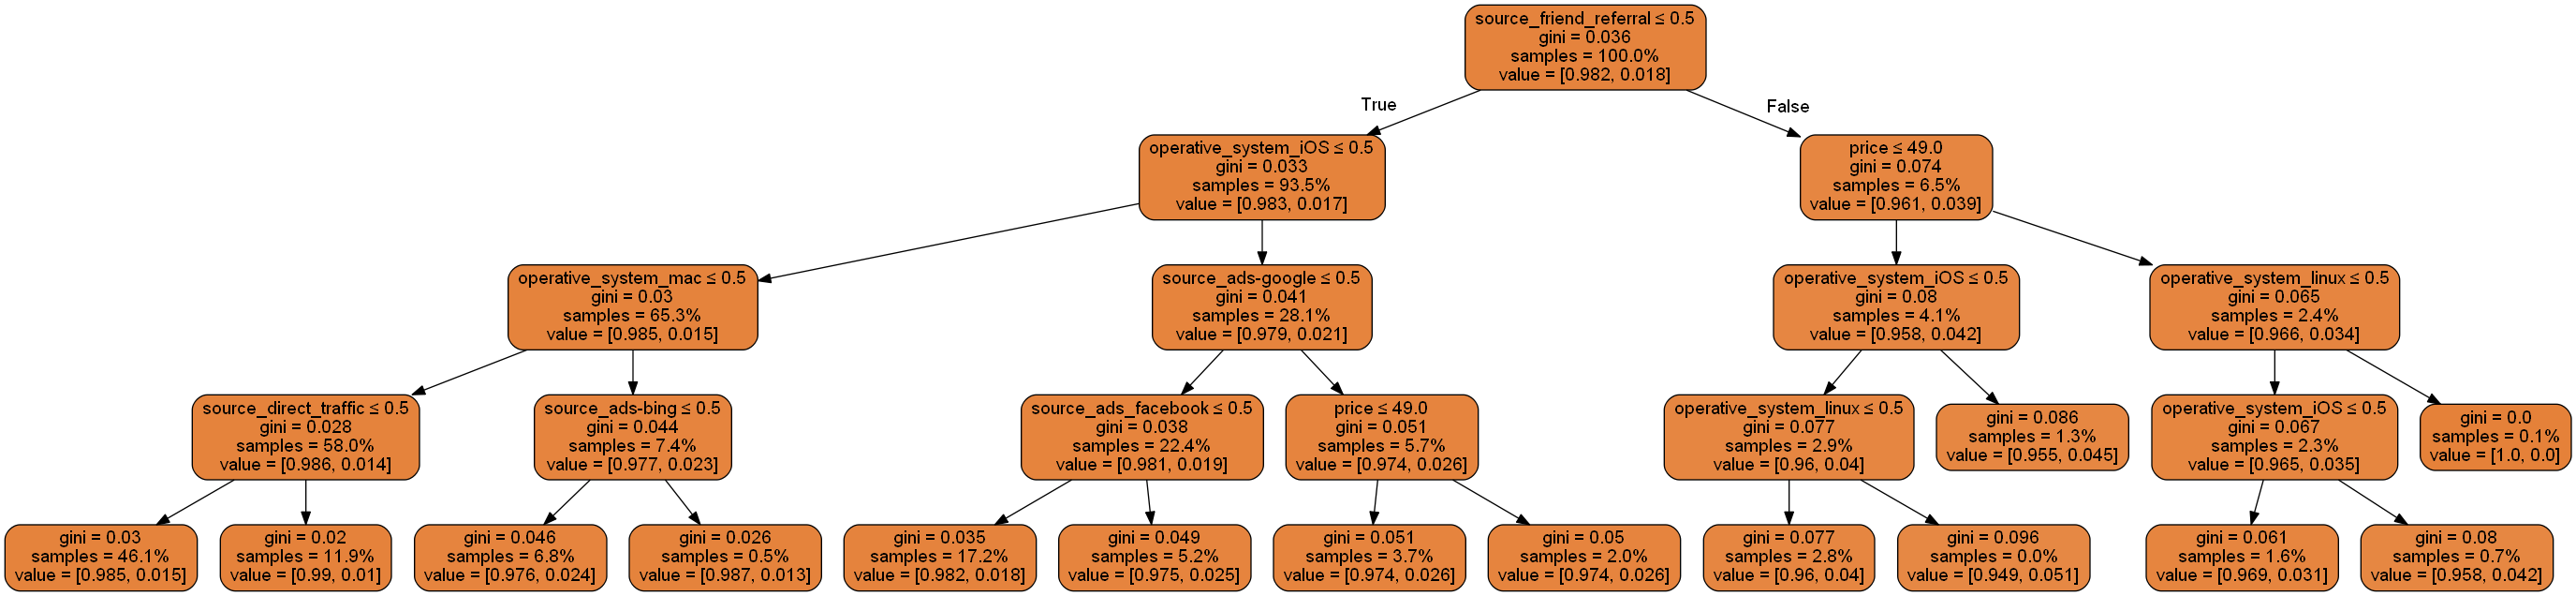

In [66]:
from sklearn.tree import export_graphviz
from io import StringIO
from IPython.display import Image  
import pydotplus


dt = DecisionTreeClassifier(max_depth=4)
dt.fit(X_train,y_train)

dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X_train.columns,proportion=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('diabetes.png')
Image(graph.create_png())

In this Decision Tree plot, the leaf with highest conversion rate is the fourth leaf from right with 'value = [0.955, 0.045]'  (which means the conversion rate=0.045), and its path is:
1. source: 'source_friend_referral' <= 0.5 is False (which means 'source_friend_referral' = 1 that is equivalent to users are from friend referral)
2. 'price' <= 49 is True (which means 'price' = 39)
3. 'operative_system_iOS'<= 0.5 is Flase (which means 'operative_system_iOS' = 1 that is equivalent to the operative system of the users is IOS)

In [67]:
pd.DataFrame(dt.feature_importances_,index = X_train.columns).sort_values(by=0, ascending=False).reset_index()

,index,0
0,source_friend_referral,0.582278
1,operative_system_iOS,0.136605
2,operative_system_mac,0.093907
3,source_direct_traffic,0.059002
4,source_ads_facebook,0.041034
5,source_ads-google,0.038543
6,price,0.020118
7,operative_system_linux,0.018002
8,source_ads-bing,0.010511
9,device_mobile,0.000000


### Conclusion

* Source:  
      (1) "friend_referral" users can generate the high revenue, company should offer more promo codes that users can send to friends
      (2) "seo-bing" can generate very high revenue, even higher than Google and FB, company can make more ads on bing search
      
* operative_system:
      (1) "mac" and "iOS" users can generate the high revenue, company should invest more resources in "Apple" users, marketing team could lauch special campaigns for "Apple" users.
      (2) "linux" users generate low revenue, and in test group they didn't generate any revenue, there might be some software problems, the development team should investigate it.

* Device:
      There is no significant difference between "web" users and "mobile" users
       
* Price:
      Low price lead to high conversion rate, high price lead to low conversion rate. BUT a high conversion rate doesn't mean it will generate more revenue, company need to find the prefect balance between "price" and "conversion rate". 
